# Компьютерное зрение. Базовый курс

## Оценка воспроизводимости детекторов ключевых точек

#### Условие

**Входные данные:** серия снимков одного документа.

**Необходимо:**

* Оценить воспроизводимость (repeatability) трёх различных детекторов ключевых точек на этих данных.

* Воспроизводимость отдельно взятой особой точки – доля кадров, в которых она обнаруживается. Среднее по всем особым точкам – repeatability детектора.

* **Примечание:** установить соответствие между парами точек можно по их дескрипторам (matching) и/или по геометрической модели движения (с некоторым допуском = погрешность модели). В качестве модели можно взять простой сдвиг. Для его оценки можно воспользоваться любым из методов анализа движения.

* Получить результат **для любых** 3 типов детекторов: Harris/Shi-Tomasi, SIFT/SURF, BRISK/ORB, ... и сравнить их между собой. Результат выразить в долях или процентах и представить в виде зависимости от номера кадра (3 графика). Измерить время работы детекторов в пересчёте на одну особую точку. Прислать исходный код решения и полученные диаграммы с графиками.

* Разрешено использовать внешние библиотеки (например, `OpenCV`) для анализа движения, поиска особых точек и вычисления их дескрипторов.

* Срок – **до 17 апреля**. Максимальный балл за задание – 20, после указанного срока – 10.

#### Решение

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
IMAGES_NUMBER = 12

In [3]:
def viewImage(image, name_of_window):
    cv2.namedWindow(name_of_window, cv2.WINDOW_NORMAL)
    cv2.imshow(name_of_window, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Все описанные ниже действия будем производить с детекторами Harris, SIFT и ORB.

1. Для каждого изображения в наборе получим особые точки с их дескрипторами и замерим время работы в пересчёте на одну особую точку. Итоговое время работы детектора вычислим как среднее по всем кадрам.

In [4]:
def get_image(i):
    if i < 10:
        return cv2.imread('./data/0' + str(i) + '.tif', cv2.IMREAD_GRAYSCALE)
    return cv2.imread('./data/' + str(i) + '.tif', cv2.IMREAD_GRAYSCALE)

In [5]:
def get_harris_keypoints():
    kps = []
    descrs = []
    times = []
    
    for i in range(1, IMAGES_NUMBER + 1):
        image = get_image(i)

        t1 = time.time()
        coords = cv2.goodFeaturesToTrack(image, maxCorners=200, qualityLevel=0.1, minDistance=10, useHarrisDetector=True)
        t2 = time.time()
        times.append((t2 - t1) / len(coords))

        kp = [cv2.KeyPoint(crd[0][0], crd[0][1], 5) for crd in coords]
        sift = cv2.SIFT_create()
        kp, des = sift.compute(image, kp)

        kps.append(kp)
        descrs.append(des)

    return sum(times) / len(times), kps, descrs

In [6]:
def get_sift_keypoints():
    kps = []
    descrs = []
    times = []
    
    for i in range(1, IMAGES_NUMBER + 1):
        image = get_image(i)

        sift = cv2.SIFT_create()

        t1 = time.time()
        kp = sift.detect(image, None)
        t2 = time.time()
        times.append((t2 - t1) / len(kp))

        kp, des = sift.compute(image, kp)

        kps.append(kp)
        descrs.append(des)

    return sum(times) / len(times), kps, descrs

In [7]:
def get_orb_keypoints():
    kps = []
    descrs = []
    times = []
    
    for i in range(1, IMAGES_NUMBER + 1):
        image = get_image(i)

        orb = cv2.ORB_create()

        t1 = time.time()
        kp = orb.detect(image, None)
        t2 = time.time()
        times.append((t2 - t1) / len(kp))

        kp, des = orb.compute(image, kp)

        kps.append(kp)
        descrs.append(des)

    return sum(times) / len(times), kps, descrs

2. Установим соответствие между парами особых точек с помощью метода ближайших соседей. В результате получим список уникальных особых точек во всём наборе изображений. Для каждой такой точки составим список изображений, которым она принадлежит.

In [8]:
def get_images_with_kps(method, kps, descrs):
    all_kps = list(kps[0])
    all_descrs = descrs[0]

    for kp, des in zip(kps[1:], descrs[1:]):
        bf = cv2.BFMatcher(cv2.NORM_HAMMING if method == 'orb' else cv2.NORM_L2)
        matches = bf.knnMatch(des, all_descrs, k=2)
        for m, n in matches:
            if not m.distance < 0.75 * n.distance:
                all_kps.append(kp[m.queryIdx])
                all_descrs = np.append(all_descrs, [des[m.queryIdx]], axis=0)

    images_with_kps = [[] for _ in range(len(all_kps))]
    for i, (kp, des) in enumerate(zip(kps, descrs)):
        bf = cv2.BFMatcher(cv2.NORM_HAMMING if method == 'orb' else cv2.NORM_L2)
        matches = bf.knnMatch(all_descrs, des, k=2)
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                images_with_kps[m.queryIdx].append(i)

    return images_with_kps

3. Далее, выполним подсчет воспроизводимости детектора. Результат выразим в долях.

In [9]:
def count_repeatability(images_with_kps):
    repeatabilities = []
    all_kps_number = len(images_with_kps)

    for img_num in range(IMAGES_NUMBER):
        found_kps_number = sum([img_num in images_list for images_list in images_with_kps])
        repeatabilities.append(found_kps_number / all_kps_number)

    return repeatabilities

4. Построим графики зависимости воспроизводимости детекторов от номера кадра.

In [10]:
def plot_repeatability(all_repeatabilities):
    image_numbers = list(range(1, IMAGES_NUMBER + 1))
    plt.figure(figsize=(12, 12))
    plt.plot(image_numbers, all_repeatabilities[0], color='cornflowerblue', label='Детектор Harris')
    plt.plot(image_numbers, all_repeatabilities[1], color='mediumvioletred', label='Детектор SIFT')
    plt.plot(image_numbers, all_repeatabilities[2], color='coral', label='Детектор ORB')
    plt.xlabel('номер кадра', fontsize=16)
    plt.ylabel('воспроизводимость', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Графики воспроизводимости детекторов в зависимости от номера кадра", fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(alpha=0.7)
    plt.show()

Итоговая функция:

In [11]:
def solve_task():
    harris_time, harris_kps, harris_descrs = get_harris_keypoints()
    sift_time, sift_kps, sift_descrs = get_sift_keypoints()
    orb_time, orb_kps, orb_descrs = get_orb_keypoints()

    harris_images_with_kps = get_images_with_kps('harris', harris_kps, harris_descrs)
    sift_images_with_kps = get_images_with_kps('sift', sift_kps, sift_descrs)
    orb_images_with_kps = get_images_with_kps('orb', orb_kps, orb_descrs)

    all_repeatabilities = []

    all_repeatabilities.append(count_repeatability(harris_images_with_kps))
    all_repeatabilities.append(count_repeatability(sift_images_with_kps))
    all_repeatabilities.append(count_repeatability(orb_images_with_kps))

    plot_repeatability(all_repeatabilities)

    print('Время работы детектора Harris: ' + str(round(harris_time * 1e6, 2)) + ' мкс / особая точка')
    print('Время работы детектора SIFT: ' + str(round(sift_time * 1e6, 2)) + ' мкс / особая точка')
    print('Время работы детектора ORB: ' + str(round(orb_time * 1e6, 2)) + ' мкс / особая точка')

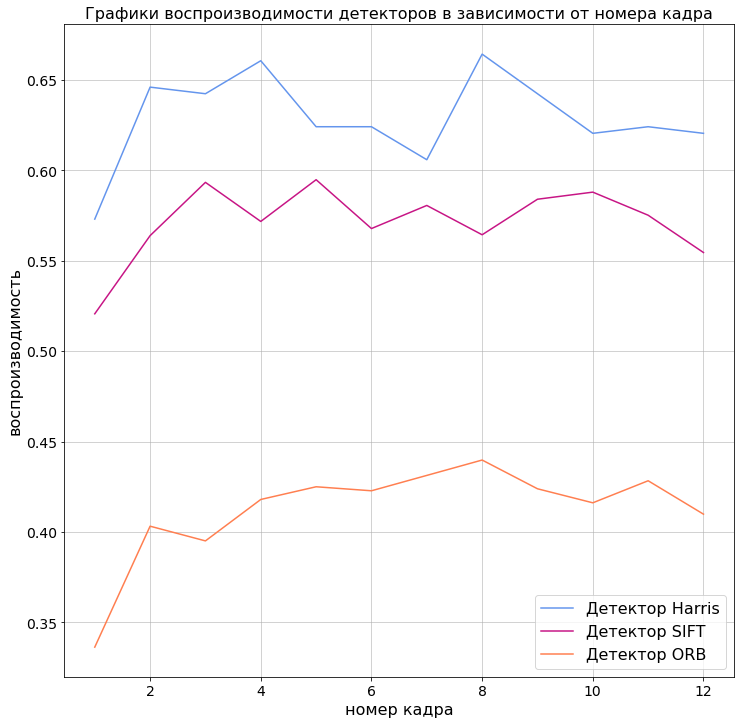

Время работы детектора Harris: 35.42 мкс / особая точка
Время работы детектора SIFT: 35.32 мкс / особая точка
Время работы детектора ORB: 4.48 мкс / особая точка


In [12]:
solve_task()